# 1-D CNN model for CAP classification 
- Authors - Shruti Murarka, Aditya Wadichar

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import csv
import pandas as pd
import scipy.io
import numpy as np
import copy

import h5py
import scipy
from PIL import Image
from scipy import ndimage

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from keras.callbacks import EarlyStopping
import tensorflow.keras.layers as tfl
import matplotlib.pyplot as plt
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model
from keras.layers.merge import concatenate
from tensorflow import keras
from time import time

from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%load_ext watermark

%watermark --iversions 

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
google    : 2.0.3
pandas    : 1.3.5
tensorflow: 2.8.0+zzzcolab20220506162203
IPython   : 5.5.0
PIL       : 7.1.2
scipy     : 1.4.1
matplotlib: 3.2.2
numpy     : 1.21.6
h5py      : 3.1.0
csv       : 1.0



## Healthy Dataset

In [ ]:
# preparing dataset
bal_all = np.loadtxt('/content/drive/MyDrive/FYP/A1_A2_A3_B_data/Data_csv/bal_healthy.csv', delimiter=',')
x_bal = bal_all[:,0:1024]
y_bal = bal_all[:,1024]
y_bal=y_bal.reshape(-1,1 )

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_bal)
onehotlabels = enc.transform(y_bal).toarray()
onelabel=np.absolute(1-onehotlabels[:,0])
onelabel=(onelabel.reshape(-1,1)).astype(np.int)
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_bal, onelabel, test_size = 0.2, shuffle = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


### Hyperparameter Optimization

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers import *
from tensorflow.keras.utils import *
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D

param = 16
kfold = KFold(n_splits=5, shuffle=True, random_state=1) 
fold_no = 1
acc_per_fold1 = []
loss_per_fold1 = []
for train, test in kfold.split(x_train1,  y_train1):
    model = Sequential()
    model.add(tfl.Conv1D(filters=32,
                    kernel_size=7,
                    strides=1,
                    padding='same',
            input_shape=(1024,1)))
   
    model.add(tfl.Conv1D(filters=8,
                    kernel_size=3,
                    strides=1,
                    padding='same', activation='relu'))
    model.add(tfl.MaxPool1D(pool_size= 16,
                       padding='same'))
    model.add(tfl.Conv1D(filters=16,
                    kernel_size=2,
                    strides=1,
                    padding='same'))
    model.add(tfl.Dropout(0.4))
    model.add(tfl.Conv1D(filters=8,
                    kernel_size=2,
                    strides=1,
                    padding='same',activation='relu'))
    model.add(tfl.MaxPool1D(pool_size= 4,
                       padding='same'))
    model.add(tfl.Flatten())
    model.add(tfl.Dense(param, activation='relu'))    ## parameter change
    model.add(tfl.Dense(1, activation='sigmoid'))
    model.compile(optimizer = 'adam',
                  loss='binary_crossentropy',
              metrics=['accuracy'])
    

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    
    # Fit data to model
    history1 = model.fit(x_train1[train], y_train1[train],
                batch_size=75,
                epochs=50)

    # Generate generalization metrics
    scores1 = model.evaluate(x_train1[test], y_train1[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores1[0]}; {model.metrics_names[1]} of {scores1[1]*100}%')
    acc_per_fold1.append(scores1[1] * 100)
    loss_per_fold1.append(scores1[0])

    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
80/80 [==============================] - 8s 76ms/step - loss: 0.8609 - accuracy: 0.5009
Epoch 2/50
80/80 [==============================] - 6s 74ms/step - loss: 0.6932 - accuracy: 0.5080
Epoch 3/50
80/80 [==============================] - 6s 74ms/step - loss: 0.6918 - accuracy: 0.5120
Epoch 4/50
80/80 [==============================] - 6s 74ms/step - loss: 0.6924 - accuracy: 0.5085
Epoch 5/50
80/80 [==============================] - 6s 74ms/step - loss: 0.6940 - accuracy: 0.5051
Epoch 6/50
80/80 [==============================] - 6s 75ms/step - loss: 0.6897 - accuracy: 0.5276
Epoch 7/50
80/80 [==============================] - 6s 74ms/step - loss: 0.6770 - accuracy: 0.5636
Epoch 8/50
80/80 [==============================] - 6s 75ms/step - loss: 0.6491 - accuracy: 0.6099
Epoch 9/50
80/80 [==============================] - 6s 75ms/step - loss: 0.6139 - accuracy: 0.6803
Epoch 10/50


In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold1)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold1[i]} - Accuracy: {acc_per_fold1[i]}%')  
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold1)} (+- {np.std(acc_per_fold1)})')
print(f'> Loss: {np.mean(loss_per_fold1)}')
print('------------------------------------------------------------------------')

#np.savetxt('/content/drive/MyDrive/FYP/Hyper_opti/dense_param4.csv', acc_per_fold1, delimiter=',')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.5087489485740662 - Accuracy: 75.08394718170166%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.48164159059524536 - Accuracy: 78.84486317634583%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.5251858234405518 - Accuracy: 73.67360591888428%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.490994393825531 - Accuracy: 77.63599753379822%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.49671509861946106 - Accuracy: 77.1505355834961%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 76.47778987884521 (+- 1.8549023099096609)
> Loss: 0.5006571710109711
----------------------------

In [ ]:
acc_per_fold4 = np.loadtxt('/content/drive/MyDrive/FYP/Hyper_opti/dense_param4.csv', delimiter=',')
acc_per_fold6 = np.loadtxt('/content/drive/MyDrive/FYP/Hyper_opti/dense_param6.csv', delimiter=',')
acc_per_fold16 = np.loadtxt('/content/drive/MyDrive/FYP/Hyper_opti/dense_param16.csv', delimiter=',')
acc_per_fold64 = np.loadtxt('/content/drive/MyDrive/FYP/Hyper_opti/dense_param64.csv', delimiter=',')

[array([79.34640646, 82.66841173, 80.37933111, 83.06082487, 82.53760338]), array([83.00653696, 83.64944458, 82.8646183 , 80.51013947, 83.19162726]), array([85.42483449, 75.34336448, 82.60300756, 70.04578114, 79.26749587]), array([50.84967613, 74.95094538, 48.7246573 , 84.1072619 , 78.74427438])]


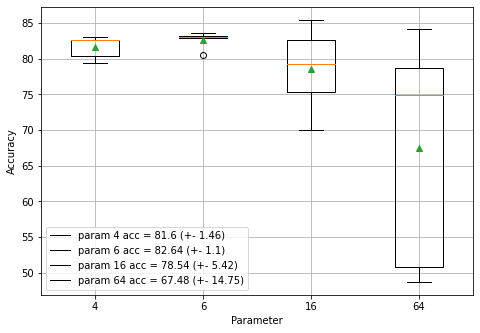

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
 
 
# Creating dataset
data_1 = np.array(acc_per_fold4)
data_2 = np.array(acc_per_fold6)
data_3 = np.array(acc_per_fold16)
data_4 = np.array(acc_per_fold64)
data = [data_1.flatten(),data_2.flatten(), data_3.flatten(), data_4.flatten()]
print(data)
fig = plt.figure()
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
#plt.ylim([60,85])

bp = ax.boxplot(data, labels=[4, 6, 16, 64], showmeans=True)
plt.xlabel('Parameter')
plt.ylabel('Accuracy')
plt.grid()

plt.legend([f'param 4 acc = {round(np.mean(acc_per_fold4),2)} (+- {round(np.std(acc_per_fold4),2)})' ,
            f'param 6 acc = {round(np.mean(acc_per_fold6),2)} (+- {round(np.std(acc_per_fold6),2)})' , 
            f'param 16 acc = {round(np.mean(acc_per_fold16),2)} (+- {round(np.std(acc_per_fold16),2)})', 
            f'param 64 acc = {round(np.mean(acc_per_fold64),2)} (+- {round(np.std(acc_per_fold64),2)})'], loc='lower left')


plt.savefig("hyper_opti.pdf", bbox_inches = 'tight')
plt.show()

### Model

In [ ]:
def CAP_phase_model(input_shape, x_train,y_train,test_data):
    """
    
    Arguments:
    input_shape, training_input, training_output, test_data

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    history
    """
    start = time()
    input_img = tf.keras.Input(shape=input_shape)
   
    Z1 = tfl.Conv1D(filters=32,
                    kernel_size=3,
                    strides=1,
                    padding='same')(input_img)
    
    Z11 = tfl.Conv1D(filters=8,
                    kernel_size=3,
                    strides=1,
                    padding='same')(Z1)
    
    A1 = tfl.ReLU()(Z11)
    
    P1 = tfl.MaxPooling1D(pool_size= 16,
                       padding='same')(A1)
    
   
    
    Z2 = tfl.Conv1D(filters=16,
                    kernel_size=2,
                    strides=1,
                    padding='same')(P1)
    Z2=tf.nn.dropout(Z2, rate = 0.4)
    
    A2 = tfl.ReLU()(Z2)
    
    P2 = tfl.MaxPooling1D(pool_size=4,
                       padding='same')(A2)



    F = tfl.Flatten()(P2)

    op2 = tfl.Dense(units=6,
                        activation='relu')(F)
          
    outputs = tfl.Dense(units=1,
                        activation='sigmoid')(op2)

    model = tf.keras.Model(inputs=input_img, outputs=outputs)

    #compile
    model.compile(optimizer = 'adam',
                  loss='binary_crossentropy',
              metrics=['accuracy'])

    model.summary()

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2)
    history_m = model.fit(x_train,y_train, epochs=150, validation_split =0.2, callbacks = [early_stopping], batch_size = 75, shuffle = True)
    
    t=time()-start
    print('Total training time:', t)
    history_m.history['training_time']=t
    
    return model, history_m

In [ ]:
conv_model, history = CAP_phase_model((1024, 1), x_train1, y_train1, (x_test1,y_test1))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 1024, 32)          128       
                                                                 
 conv1d_1 (Conv1D)           (None, 1024, 8)           776       
                                                                 
 re_lu (ReLU)                (None, 1024, 8)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 64, 8)            0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 64, 16)            272       
                                                             

In [ ]:
# save model, history and training and test dataset
conv_model.save('/content/drive/MyDrive/FYP/CNN/Un-healthy/model_v2.h5')
np.save('/content/drive/MyDrive/FYP/CNN/Un-healthy/ver2_history.npy', history)

# save testdata to csv file
np.savetxt('/content/drive/MyDrive/FYP/CNN/Un-healthy/xtest_data_ver2.csv', x_test1, delimiter=',')
np.savetxt('/content/drive/MyDrive/FYP/CNN/Un-healthy/ytest_data_ver2.csv', y_test1, delimiter=',')
np.savetxt('/content/drive/MyDrive/FYP/CNN/Un-healthy/xtrain_data_ver2.csv', x_train1, delimiter=',')
np.savetxt('/content/drive/MyDrive/FYP/CNN/Un-healthy/ytrain_data_ver2.csv', y_train1, delimiter=',')

### Results

Healthy

In [11]:
# load model, history and dataset
conv_model = tf.keras.models.load_model('/content/drive/MyDrive/GUI/GUI/healthy_cap.h5')
history=np.load('/content/drive/MyDrive/GUI/Data/healthy_cap_hist.npy',allow_pickle='TRUE').item()
x_test1 = np.loadtxt('/content/drive/MyDrive/GUI/Data/healthy_cap_xtest.csv', delimiter=',')
y_test1 = np.loadtxt('/content/drive/MyDrive/GUI/Data/healthy_cap_ytest.csv', delimiter=',')
disease='Healthy'   # disorder of loded dataset

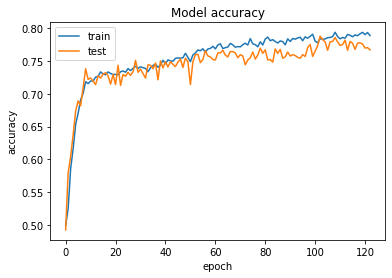

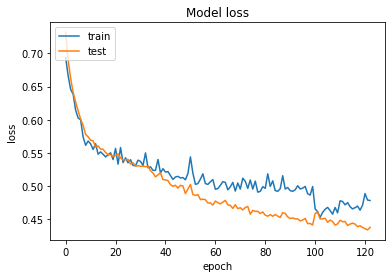

Patient: Healthy
59/59 - 1s - 552ms/epoch - 9ms/step
Accuracy: 0.772288
Specificity: 0.745614
Precision: 0.805024
Sensitivity: 0.720557
F1 score: 0.760452
Cohens kappa: 0.544725


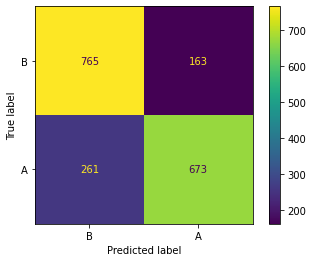

In [12]:
    ## GRAPHS FROM RESTORE MODEL

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print('Patient:',disease)
prob = conv_model.predict(x_test1,verbose = 2)
pred = (prob > 0.5).astype("int32")

# reduce to 1d array
yhat_probs = prob[:, 0]
yhat_classes = pred[:, 0]

cm=metrics.confusion_matrix(y_test1,pred)
# accuracy: (tp + tn) / (p + n)
accuracy = metrics.accuracy_score(y_test1,pred)
print('Accuracy: %f' % accuracy)
# specificity = tn(tn+fp)
specificity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Specificity: %f' % specificity)
# precision tp / (tp + fp)
precision = metrics.precision_score(y_test1,pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = metrics.recall_score(y_test1, pred)
print('Sensitivity: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(y_test1, pred)
print('F1 score: %f' % f1)
# kappa
kappa = metrics.cohen_kappa_score(y_test1, pred)
print('Cohens kappa: %f' % kappa)

labels=["B", "A"]
cm=metrics.confusion_matrix(y_test1,pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

Patient: Healthy
Actual = B, Predection = B


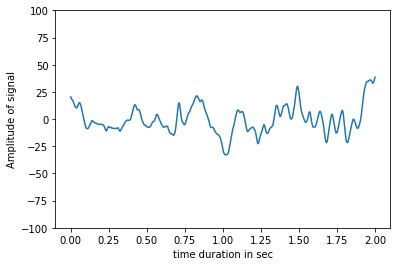

In [13]:
labels=["B", "A"]
index=4
#pred = new_model.predict(x_test1)
real=y_test1
prediction=0
if (pred[index]>=0.5): prediction=1
act=labels[int(real[index])]
pr=labels[prediction]
print("Patient:", disease)
print ("Actual = " + act + ", Predection = " + pr)
plt.plot(np.arange(1024)/512 ,x_test1[index,:])
plt.xlabel("time duration in sec")
plt.ylabel("Amplitude of signal")
plt.ylim([-100, 100])
plt.show()

Text(0.5, 0, 'False positive rate')

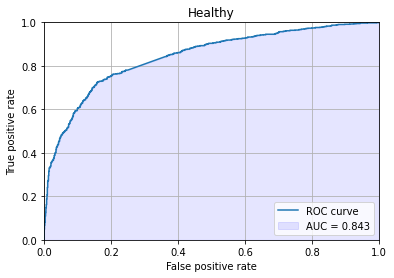

In [14]:
y_pred_keras = conv_model.predict(x_test1).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test1, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.title(disease)
plt.plot(fpr_keras, tpr_keras, label='ROC curve')
plt.fill_between(fpr_keras, tpr_keras, 0, color='blue', alpha=.1, label='AUC = {:.3f}'.format(auc_keras))
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc='lower right')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

Insomnia

In [15]:
# load model, history and dataset
conv_model = tf.keras.models.load_model('/content/drive/MyDrive/GUI/GUI/ins_cap.h5')
history=np.load('/content/drive/MyDrive/GUI/Data/ins_cap_hist.npy',allow_pickle='TRUE').item()
x_test1 = np.loadtxt('/content/drive/MyDrive/GUI/Data/ins_cap_xtest.csv', delimiter=',')
y_test1 = np.loadtxt('/content/drive/MyDrive/GUI/Data/ins_cap_ytest.csv', delimiter=',')
disease='Insomnia'   # disorder of loded dataset

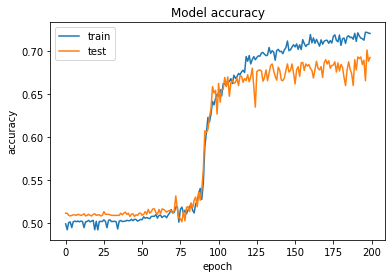

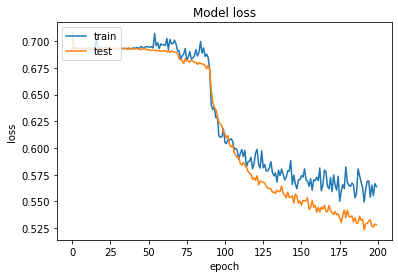

Patient: Insomnia
63/63 - 1s - 575ms/epoch - 9ms/step
Accuracy: 0.687249
Specificity: 0.652107
Precision: 0.754003
Sensitivity: 0.532922
F1 score: 0.624473
Cohens kappa: 0.369787


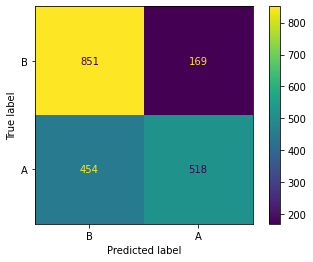

In [16]:
    ## GRAPHS FROM RESTORE MODEL

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print('Patient:',disease)
prob = conv_model.predict(x_test1,verbose = 2)
pred = (prob > 0.5).astype("int32")

# reduce to 1d array
yhat_probs = prob[:, 0]
yhat_classes = pred[:, 0]

cm=metrics.confusion_matrix(y_test1,pred)
# accuracy: (tp + tn) / (p + n)
accuracy = metrics.accuracy_score(y_test1,pred)
print('Accuracy: %f' % accuracy)
# specificity = tn(tn+fp)
specificity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Specificity: %f' % specificity)
# precision tp / (tp + fp)
precision = metrics.precision_score(y_test1,pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = metrics.recall_score(y_test1, pred)
print('Sensitivity: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(y_test1, pred)
print('F1 score: %f' % f1)
# kappa
kappa = metrics.cohen_kappa_score(y_test1, pred)
print('Cohens kappa: %f' % kappa)

labels=["B", "A"]
cm=metrics.confusion_matrix(y_test1,pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

Patient: Insomnia
Actual = A, Predection = A


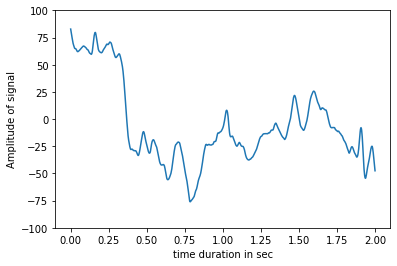

In [17]:
labels=["B", "A"]
index=4
#pred = new_model.predict(x_test1)
real=y_test1
prediction=0
if (pred[index]>=0.5): prediction=1
act=labels[int(real[index])]
pr=labels[prediction]
print("Patient:", disease)
print ("Actual = " + act + ", Predection = " + pr)
plt.plot(np.arange(1024)/512 ,x_test1[index,:])
plt.xlabel("time duration in sec")
plt.ylabel("Amplitude of signal")
plt.ylim([-100, 100])
plt.show()

Text(0.5, 0, 'False positive rate')

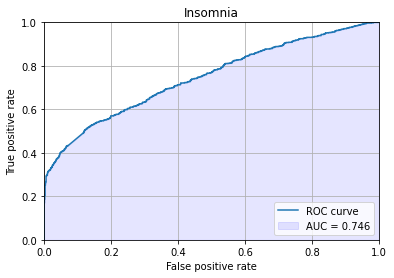

In [18]:
y_pred_keras = conv_model.predict(x_test1).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test1, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.title(disease)
plt.plot(fpr_keras, tpr_keras, label='ROC curve')
plt.fill_between(fpr_keras, tpr_keras, 0, color='blue', alpha=.1, label='AUC = {:.3f}'.format(auc_keras))
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc='lower right')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

Narcolepsy

In [20]:
# load model, history and dataset
conv_model = tf.keras.models.load_model('/content/drive/MyDrive/GUI/GUI/narco_cap.h5')
history=np.load('/content/drive/MyDrive/GUI/Data/narco_cap_hist.npy',allow_pickle='TRUE').item()
x_test1 = np.loadtxt('/content/drive/MyDrive/GUI/Data/narco_cap_xtest.csv', delimiter=',')
y_test1 = np.loadtxt('/content/drive/MyDrive/GUI/Data/narco_cap_ytest.csv', delimiter=',')
disease='Narcolepsy'   # disorder of loded dataset

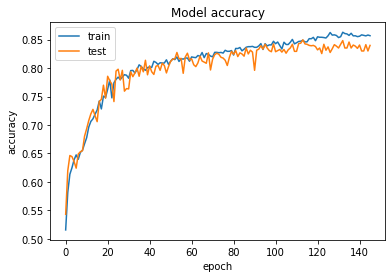

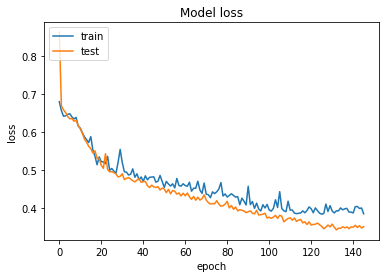

Patient: Narcolepsy
60/60 - 1s - 553ms/epoch - 9ms/step
Accuracy: 0.832636
Specificity: 0.836887
Precision: 0.828542
Sensitivity: 0.840625
F1 score: 0.834540
Cohens kappa: 0.665246


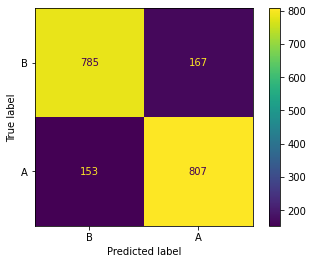

In [21]:
    ## GRAPHS FROM RESTORE MODEL

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print('Patient:',disease)
prob = conv_model.predict(x_test1,verbose = 2)
pred = (prob > 0.5).astype("int32")

# reduce to 1d array
yhat_probs = prob[:, 0]
yhat_classes = pred[:, 0]

cm=metrics.confusion_matrix(y_test1,pred)
# accuracy: (tp + tn) / (p + n)
accuracy = metrics.accuracy_score(y_test1,pred)
print('Accuracy: %f' % accuracy)
# specificity = tn(tn+fp)
specificity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Specificity: %f' % specificity)
# precision tp / (tp + fp)
precision = metrics.precision_score(y_test1,pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = metrics.recall_score(y_test1, pred)
print('Sensitivity: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(y_test1, pred)
print('F1 score: %f' % f1)
# kappa
kappa = metrics.cohen_kappa_score(y_test1, pred)
print('Cohens kappa: %f' % kappa)

labels=["B", "A"]
cm=metrics.confusion_matrix(y_test1,pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

Patient: Narcolepsy
Actual = A, Predection = A


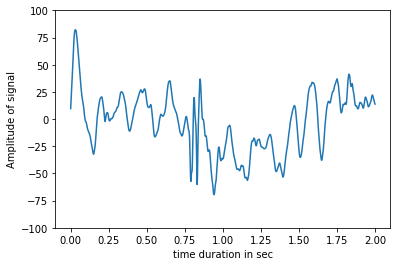

In [22]:
labels=["B", "A"]
index=4
#pred = new_model.predict(x_test1)
real=y_test1
prediction=0
if (pred[index]>=0.5): prediction=1
act=labels[int(real[index])]
pr=labels[prediction]
print("Patient:", disease)
print ("Actual = " + act + ", Predection = " + pr)
plt.plot(np.arange(1024)/512 ,x_test1[index,:])
plt.xlabel("time duration in sec")
plt.ylabel("Amplitude of signal")
plt.ylim([-100, 100])
plt.show()

Text(0.5, 0, 'False positive rate')

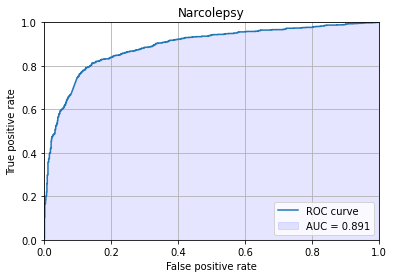

In [23]:
y_pred_keras = conv_model.predict(x_test1).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test1, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.title(disease)
plt.plot(fpr_keras, tpr_keras, label='ROC curve')
plt.fill_between(fpr_keras, tpr_keras, 0, color='blue', alpha=.1, label='AUC = {:.3f}'.format(auc_keras))
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc='lower right')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

NFLE

In [24]:
# load model, history and dataset
conv_model = tf.keras.models.load_model('/content/drive/MyDrive/GUI/GUI/nfle_cap.h5')
history=np.load('/content/drive/MyDrive/GUI/Data/nfle_cap_hist.npy',allow_pickle='TRUE').item()
x_test1 = np.loadtxt('/content/drive/MyDrive/GUI/Data/nfle_cap_xtest.csv', delimiter=',')
y_test1 = np.loadtxt('/content/drive/MyDrive/GUI/Data/nfle_cap_ytest.csv', delimiter=',')
disease='NFLE'   # disorder of loded dataset

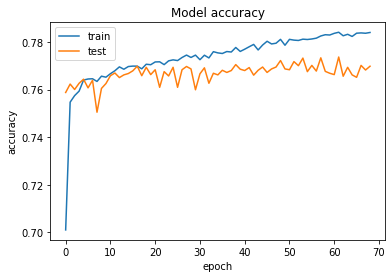

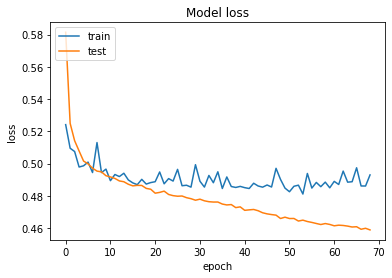

Patient: NFLE
458/458 - 3s - 3s/epoch - 8ms/step
Accuracy: 0.766862
Specificity: 0.797615
Precision: 0.740867
Sensitivity: 0.812405
F1 score: 0.774988
Cohens kappa: 0.534178


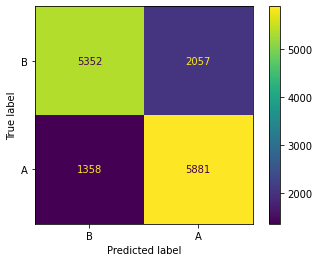

In [25]:
    ## GRAPHS FROM RESTORE MODEL

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print('Patient:',disease)
prob = conv_model.predict(x_test1,verbose = 2)
pred = (prob > 0.5).astype("int32")

# reduce to 1d array
yhat_probs = prob[:, 0]
yhat_classes = pred[:, 0]

cm=metrics.confusion_matrix(y_test1,pred)
# accuracy: (tp + tn) / (p + n)
accuracy = metrics.accuracy_score(y_test1,pred)
print('Accuracy: %f' % accuracy)
# specificity = tn(tn+fp)
specificity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Specificity: %f' % specificity)
# precision tp / (tp + fp)
precision = metrics.precision_score(y_test1,pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = metrics.recall_score(y_test1, pred)
print('Sensitivity: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(y_test1, pred)
print('F1 score: %f' % f1)
# kappa
kappa = metrics.cohen_kappa_score(y_test1, pred)
print('Cohens kappa: %f' % kappa)

labels=["B", "A"]
cm=metrics.confusion_matrix(y_test1,pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

Patient: NFLE
Actual = B, Predection = B


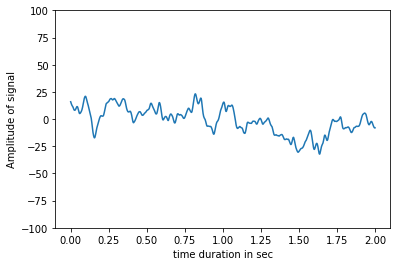

In [26]:
labels=["B", "A"]
index=4
#pred = new_model.predict(x_test1)
real=y_test1
prediction=0
if (pred[index]>=0.5): prediction=1
act=labels[int(real[index])]
pr=labels[prediction]
print("Patient:", disease)
print ("Actual = " + act + ", Predection = " + pr)
plt.plot(np.arange(1024)/512 ,x_test1[index,:])
plt.xlabel("time duration in sec")
plt.ylabel("Amplitude of signal")
plt.ylim([-100, 100])
plt.show()

Text(0.5, 0, 'False positive rate')

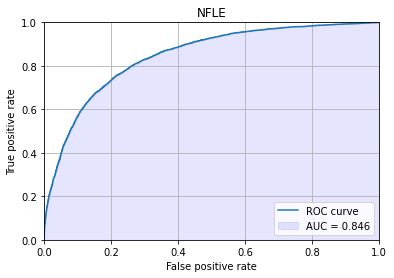

In [27]:
y_pred_keras = conv_model.predict(x_test1).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test1, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.title(disease)
plt.plot(fpr_keras, tpr_keras, label='ROC curve')
plt.fill_between(fpr_keras, tpr_keras, 0, color='blue', alpha=.1, label='AUC = {:.3f}'.format(auc_keras))
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc='lower right')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

RBD

In [28]:
# load model, history and dataset
conv_model = tf.keras.models.load_model('/content/drive/MyDrive/GUI/GUI/rbd_cap.h5')
history=np.load('/content/drive/MyDrive/GUI/Data/rbd_cap_hist.npy',allow_pickle='TRUE').item()
x_test1 = np.loadtxt('/content/drive/MyDrive/GUI/Data/rbd_cap_xtest.csv', delimiter=',')
y_test1 = np.loadtxt('/content/drive/MyDrive/GUI/Data/rbd_cap_ytest.csv', delimiter=',')
disease='RBD'   # disorder of loded dataset

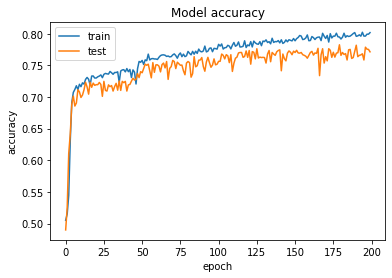

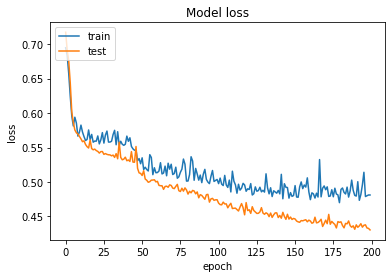

Patient: RBD
276/276 - 2s - 2s/epoch - 8ms/step
Accuracy: 0.790172
Specificity: 0.751910
Precision: 0.839760
Sensitivity: 0.723132
F1 score: 0.777095
Cohens kappa: 0.580970


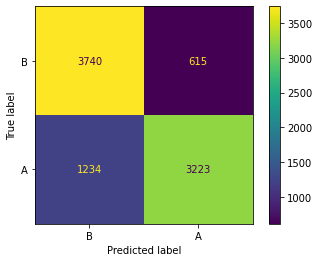

In [29]:
    ## GRAPHS FROM RESTORE MODEL

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print('Patient:',disease)
prob = conv_model.predict(x_test1,verbose = 2)
pred = (prob > 0.5).astype("int32")

# reduce to 1d array
yhat_probs = prob[:, 0]
yhat_classes = pred[:, 0]

cm=metrics.confusion_matrix(y_test1,pred)
# accuracy: (tp + tn) / (p + n)
accuracy = metrics.accuracy_score(y_test1,pred)
print('Accuracy: %f' % accuracy)
# specificity = tn(tn+fp)
specificity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Specificity: %f' % specificity)
# precision tp / (tp + fp)
precision = metrics.precision_score(y_test1,pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = metrics.recall_score(y_test1, pred)
print('Sensitivity: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(y_test1, pred)
print('F1 score: %f' % f1)
# kappa
kappa = metrics.cohen_kappa_score(y_test1, pred)
print('Cohens kappa: %f' % kappa)

labels=["B", "A"]
cm=metrics.confusion_matrix(y_test1,pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

Patient: RBD
Actual = B, Predection = B


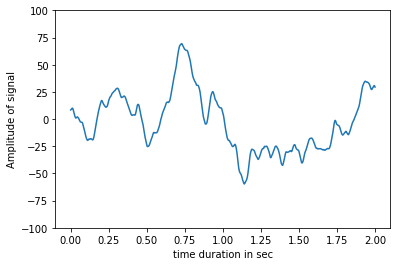

In [30]:
labels=["B", "A"]
index=4
#pred = new_model.predict(x_test1)
real=y_test1
prediction=0
if (pred[index]>=0.5): prediction=1
act=labels[int(real[index])]
pr=labels[prediction]
print("Patient:", disease)
print ("Actual = " + act + ", Predection = " + pr)
plt.plot(np.arange(1024)/512 ,x_test1[index,:])
plt.xlabel("time duration in sec")
plt.ylabel("Amplitude of signal")
plt.ylim([-100, 100])
plt.show()

Text(0.5, 0, 'False positive rate')

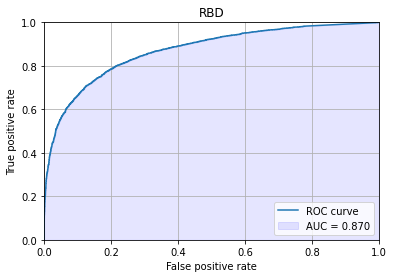

In [31]:
y_pred_keras = conv_model.predict(x_test1).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test1, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.title(disease)
plt.plot(fpr_keras, tpr_keras, label='ROC curve')
plt.fill_between(fpr_keras, tpr_keras, 0, color='blue', alpha=.1, label='AUC = {:.3f}'.format(auc_keras))
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc='lower right')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

PLM

In [36]:
# load model, history and dataset
conv_model = tf.keras.models.load_model('/content/drive/MyDrive/GUI/GUI/plm_cap.h5')
history=np.load('/content/drive/MyDrive/GUI/Data/plm_cap_hist.npy',allow_pickle='TRUE').item()
x_test1 = np.loadtxt('/content/drive/MyDrive/GUI/Data/plm_cap_xtest.csv', delimiter=',')
y_test1 = np.loadtxt('/content/drive/MyDrive/GUI/Data/plm_cap_ytest.csv', delimiter=',')
disease='PLM'   # disorder of loded dataset

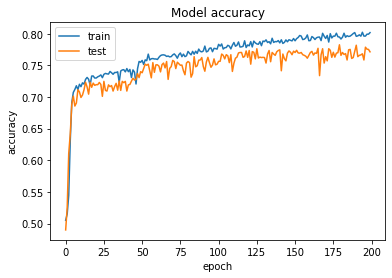

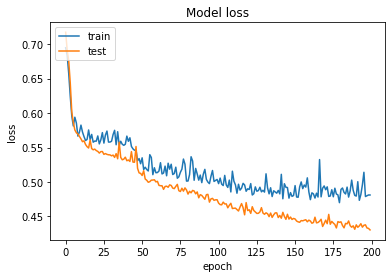

Patient: PLM
113/113 - 1s - 985ms/epoch - 9ms/step
Accuracy: 0.785057
Specificity: 0.746305
Precision: 0.835581
Sensitivity: 0.716410
F1 score: 0.771420
Cohens kappa: 0.570824


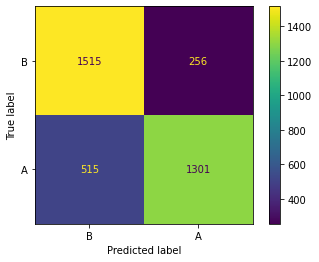

In [37]:
    ## GRAPHS FROM RESTORE MODEL

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print('Patient:',disease)
prob = conv_model.predict(x_test1,verbose = 2)
pred = (prob > 0.5).astype("int32")

# reduce to 1d array
yhat_probs = prob[:, 0]
yhat_classes = pred[:, 0]

cm=metrics.confusion_matrix(y_test1,pred)
# accuracy: (tp + tn) / (p + n)
accuracy = metrics.accuracy_score(y_test1,pred)
print('Accuracy: %f' % accuracy)
# specificity = tn(tn+fp)
specificity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Specificity: %f' % specificity)
# precision tp / (tp + fp)
precision = metrics.precision_score(y_test1,pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = metrics.recall_score(y_test1, pred)
print('Sensitivity: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(y_test1, pred)
print('F1 score: %f' % f1)
# kappa
kappa = metrics.cohen_kappa_score(y_test1, pred)
print('Cohens kappa: %f' % kappa)

labels=["B", "A"]
cm=metrics.confusion_matrix(y_test1,pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

Patient: PLM
Actual = B, Predection = B


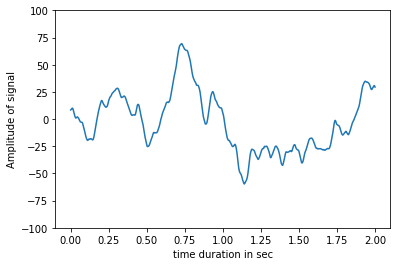

In [38]:
labels=["B", "A"]
index=4
#pred = new_model.predict(x_test1)
real=y_test1
prediction=0
if (pred[index]>=0.5): prediction=1
act=labels[int(real[index])]
pr=labels[prediction]
print("Patient:", disease)
print ("Actual = " + act + ", Predection = " + pr)
plt.plot(np.arange(1024)/512 ,x_test1[index,:])
plt.xlabel("time duration in sec")
plt.ylabel("Amplitude of signal")
plt.ylim([-100, 100])
plt.show()

Text(0.5, 0, 'False positive rate')

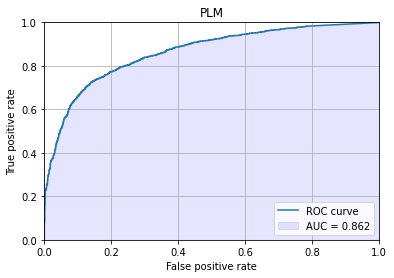

In [39]:
y_pred_keras = conv_model.predict(x_test1).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test1, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.title(disease)
plt.plot(fpr_keras, tpr_keras, label='ROC curve')
plt.fill_between(fpr_keras, tpr_keras, 0, color='blue', alpha=.1, label='AUC = {:.3f}'.format(auc_keras))
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc='lower right')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')